In [1]:
from IPython.display import Image

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import cv2
import numpy as np
from pathlib import Path

In [4]:
import os

In [5]:
os.listdir()

['k.png',
 'lichess empty.png',
 'n.png',
 'board.png',
 'annotation_bad.png',
 '.ipynb_checkpoints',
 'b.png',
 'Pieces.ipynb',
 'annotation_good.png',
 'r.png',
 'p.png',
 'lichess full.png',
 'q.png']

In [6]:
x = Image("lichess full.png", width=400)
y = Image("lichess empty.png", width=400)

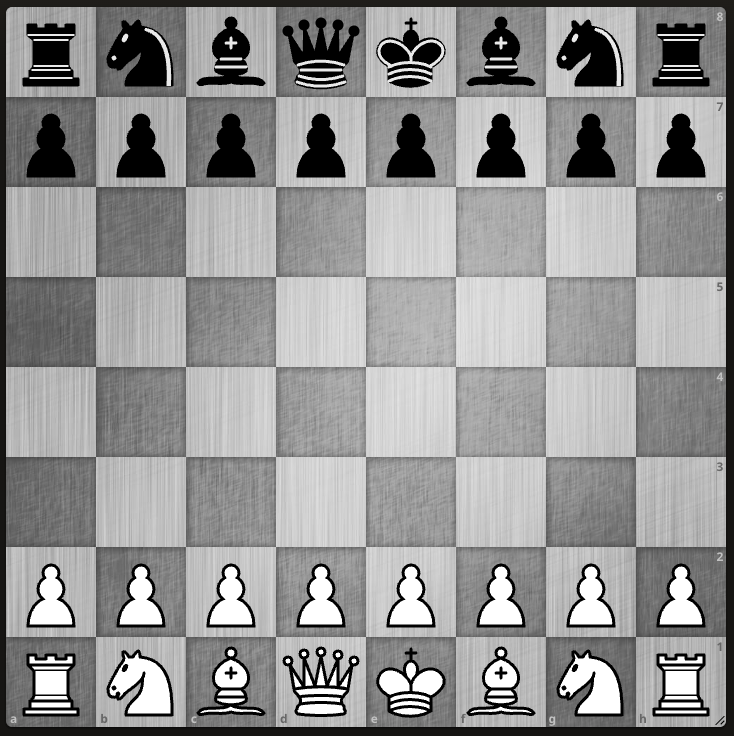

In [7]:
x

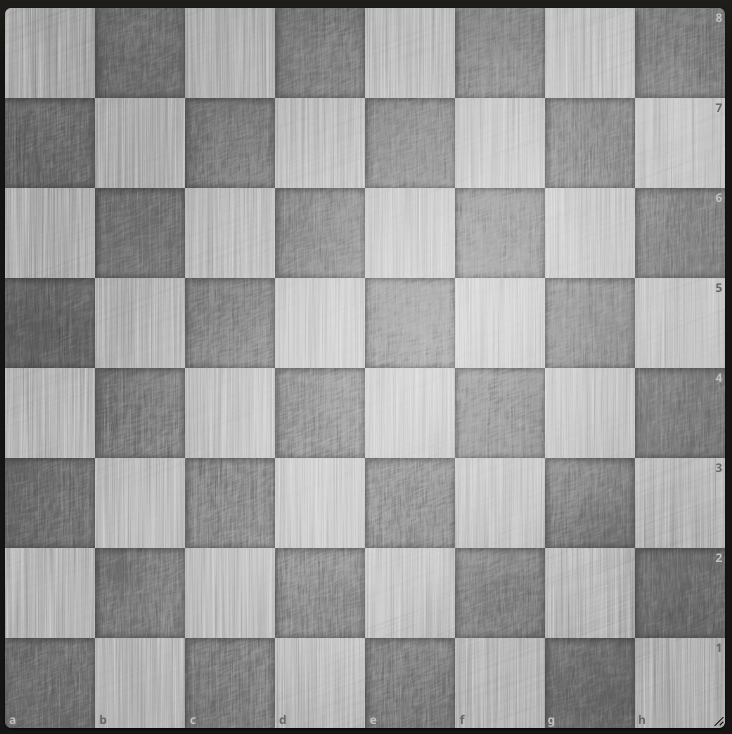

In [8]:
y

In [9]:
image = cv2.imread("lichess full.png")

In [10]:
def find_border(imgin):
    img = np.copy(imgin)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 0, 127, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Remove OTSU for pieces
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_ix = -1
    for (ix, c) in enumerate(contours):
        if cv2.contourArea(c) > max_area:
            max_area = cv2.contourArea(c)
            best_ix = ix
    cv2.drawContours(img, contours, best_ix, (255,0,0), 3)
    return (img, contours[best_ix])

In [11]:
def cropto(imgin, contour):
    xs = contour[:,:,0]
    ys = contour[:,:,1]
    x = np.min(xs)
    w = np.max(xs) - x
    y = np.min(ys)
    h = np.max(ys) - y
    return imgin[y:y+h, x:x+w]

In [12]:
def pieces_mask(baseimage, fullimage):
    diffimage = cv2.absdiff(baseimage, fullimage)
    imgray = cv2.cvtColor(diffimage, cv2.COLOR_BGR2GRAY)
    _, maskimage = cv2.threshold(imgray, 1, 255, cv2.THRESH_BINARY)
    return maskimage

In [13]:
def apply_mask(baseimage, maskimage):
    mask = np.where((maskimage==0), 0, 255).astype(np.uint8)
    masked = cv2.bitwise_and(baseimage, baseimage, mask=mask)
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2BGRA)
    masked[:, :, 3] = mask
    return masked

In [14]:
def cropmask(shape):
    squares = 8
    width = shape[0]
    height = shape[1]
    xoff = width / squares
    yoff = height / squares
    crosslen = 10
    sidelen = (width / squares) - 4
    
    mask = np.zeros(shape[:2], np.uint8)
    cuts = np.zeros(shape[:2], np.uint8)
    for y in range(0, squares):
        for x in range(0, squares):
            centerx = int(np.round(xoff / 2 + x * xoff))
            centery = int(np.round(yoff / 2 + y * yoff))
            cv2.line(mask, (centerx - crosslen, centery), (centerx + crosslen, centery), (255), 4)
            cv2.line(mask, (centerx, centery - crosslen), (centerx, centery + crosslen), (255), 4)

            x1 = int(np.round(centerx - (sidelen / 2)))
            x2 = int(np.round(centerx + (sidelen / 2)))
            y1 = int(np.round(centery - (sidelen / 2)))
            y2 = int(np.round(centery + (sidelen / 2)))

            cv2.line(cuts, (x1, y1), (x2, y1), (255), 1)
            cv2.line(cuts, (x2, y1), (x2, y2), (255), 1)
            cv2.line(cuts, (x2, y2), (x1, y2), (255), 1)
            cv2.line(cuts, (x1, y2), (x1, y1), (255), 1)
    outimage = np.zeros(shape[:2] + (4,), np.uint8)
    outimage[:, :, 0] = mask
    outimage[:, :, 3] = np.maximum(mask, cuts)
    outimage[:, :, 2] = cuts
    return outimage

In [34]:
def chop_save(pieces, center, sidelen, filename, outarray):
    x = center[0]
    y = center[1]
    x1 = int(np.round(x - sidelen / 2))
    y1 = int(np.round(y - sidelen / 2))
    x2 = int(np.round(x + sidelen / 2))
    y2 = int(np.round(y + sidelen / 2))
    
    chopped = pieces[y1:y2, x1:x2]
    outarray.append(chopped)
    cv2.imwrite(filename, chopped)

def save_pieces(pieces):
    outarray = []
    shape = pieces.shape
    squares = 8
    width = shape[0]
    height = shape[1]
    xoff = width / squares
    yoff = height / squares
    sidelen = (width / squares) - 4

    r = (int(np.round(xoff / 2)), int(np.round(yoff / 2)))
    n = (int(np.round(xoff / 2 + xoff)), int(np.round(yoff / 2)))
    b = (int(np.round(xoff / 2 + (2 * xoff))), int(np.round(yoff / 2)))
    q = (int(np.round(xoff / 2 + (3 * xoff))), int(np.round(yoff / 2)))
    k = (int(np.round(xoff / 2 + (4 * xoff))), int(np.round(yoff / 2)))
    p = (int(np.round(xoff / 2)), int(np.round(yoff / 2 + yoff)))

    R = (int(np.round(xoff / 2)), int(np.round(yoff / 2 + (7 * yoff))))
    N = (int(np.round(xoff / 2 + xoff)), int(np.round(yoff / 2 + (7 * yoff))))
    B = (int(np.round(xoff / 2 + (2 * xoff))), int(np.round(yoff / 2 + (7 * yoff))))
    Q = (int(np.round(xoff / 2 + (3 * xoff))), int(np.round(yoff / 2 + (7 * yoff))))
    K = (int(np.round(xoff / 2 + (4 * xoff))), int(np.round(yoff / 2 + (7 * yoff))))
    P = (int(np.round(xoff / 2)), int(np.round(yoff / 2 + (6 * yoff))))

    chop_save(pieces, r, sidelen, "br.png", outarray)
    chop_save(pieces, n, sidelen, "bn.png", outarray)
    chop_save(pieces, b, sidelen, "bb.png", outarray)
    chop_save(pieces, q, sidelen, "bq.png", outarray)
    chop_save(pieces, k, sidelen, "bk.png", outarray)
    chop_save(pieces, p, sidelen, "bp.png", outarray)
    
    chop_save(pieces, R, sidelen, "wR.png", outarray)
    chop_save(pieces, N, sidelen, "wN.png", outarray)
    chop_save(pieces, B, sidelen, "wB.png", outarray)
    chop_save(pieces, Q, sidelen, "wQ.png", outarray)
    chop_save(pieces, K, sidelen, "wK.png", outarray)
    chop_save(pieces, P, sidelen, "wP.png", outarray)
    return outarray

In [16]:
def border_img(img, color, width):
    minx = int(np.round(width / 2))
    miny = int(np.round(width / 2))
    maxx = img.shape[0] - 1 - minx
    maxy = img.shape[1] - 1 - miny
    cv2.line(img, (minx, miny), (maxx, miny), color, width)
    cv2.line(img, (maxx, miny), (maxx, maxy), color, width)
    cv2.line(img, (maxx, maxy), (minx, maxy), color, width)
    cv2.line(img, (minx, maxy), (minx, miny), color, width)

In [17]:
(res, contour) = find_border(image)

In [18]:
cropped = cropto(image, contour)

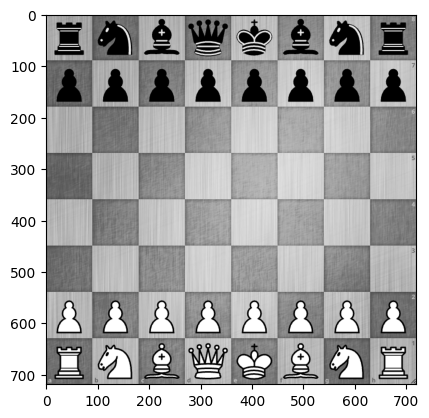

In [19]:
plt.imshow(cropped)

In [20]:
baseimage = cv2.imread("lichess empty.png")

In [21]:
(res, contour) = find_border(baseimage)

In [22]:
basecropped = cropto(baseimage, contour)

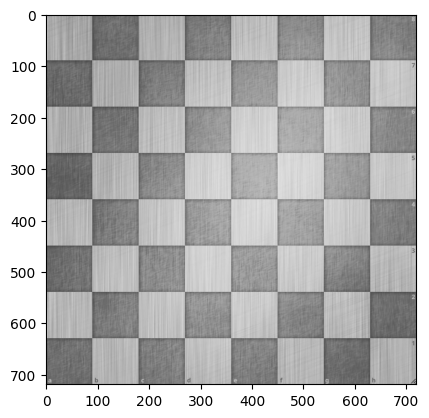

In [23]:
plt.imshow(basecropped)

In [24]:
maskimage = pieces_mask(basecropped, cropped)

In [25]:
pieces = apply_mask(cropped, maskimage)

In [26]:
cutting_mask=cropmask(cropped.shape)

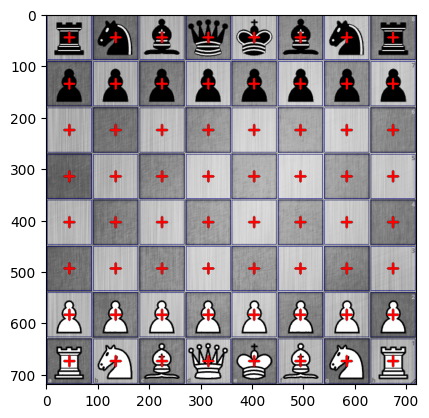

In [27]:
fig, ax = plt.subplots()
ax.imshow(basecropped)
ax.imshow(pieces)
ax.imshow(cutting_mask)
plt.show()

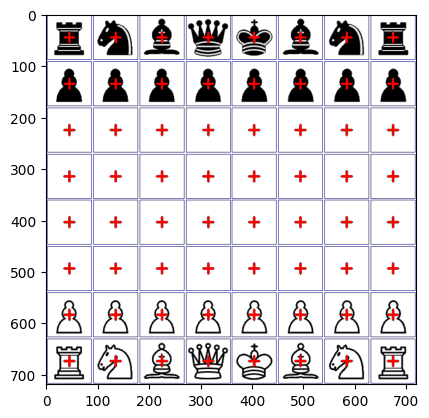

In [28]:
fig, ax = plt.subplots()
ax.imshow(pieces)
ax.imshow(cutting_mask)
plt.show()

In [35]:
them = save_pieces(pieces)

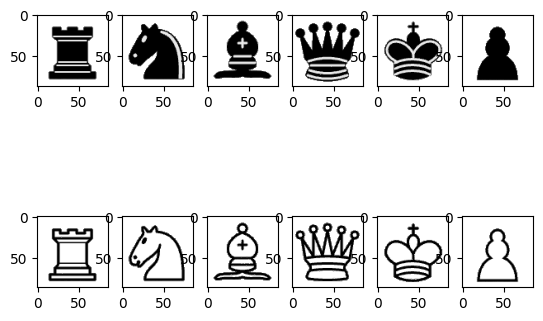

In [30]:
fig, axs = plt.subplots(2, 6)
row = 0
for i, img in enumerate(them):
    axs[row, i - (row * 6)].imshow(img)
    if i == 5:
        row += 1

In [31]:
cv2.imwrite("board.png", basecropped)

True

In [32]:
# Hello

In [33]:
them[0].shape

(86, 86, 4)

In [34]:
annotation_bad = np.zeros(them[0].shape, np.uint8)

In [35]:
annotation_good = np.zeros(them[0].shape, np.uint8)

In [36]:
border_img(annotation_bad, (255, 0, 0, 255), 2)

In [37]:
border_img(annotation_good, (0, 255, 0, 255), 2)

In [38]:
_ = cv2.line(annotation_bad, (0, 0), annotation_bad.shape[:2], (255, 0, 0, 255), 2)

In [39]:
_ = cv2.line(annotation_bad, (annotation_bad.shape[0], 0), (0, annotation_bad.shape[1]), (255, 0, 0, 255), 2)

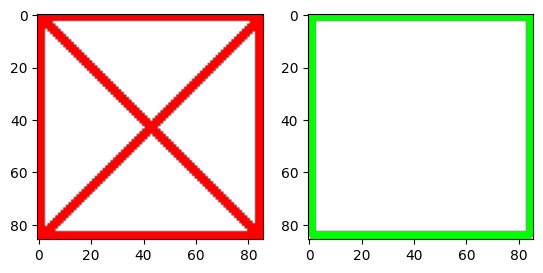

In [40]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(annotation_bad)
axs[1].imshow(annotation_good)

In [190]:
cv2.imwrite('annotation_bad.png', annotation_bad)

True

In [191]:
cv2.imwrite('annotation_good.png', annotation_good)

True